In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.signal import argrelextrema, find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [3]:
def quantile_norm(pred1, pred2):
    l = pred1.shape[0]
    pred1_diag = np.array([np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred2_diag = np.array([np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sorted = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sorted.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1,200), df_qn[1].values.reshape(-1,200)
    
    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l-i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn

In [4]:
chrom = 16
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred1_qn, pred2_qn = quantile_norm(pred1, pred2)

In [5]:
def topdom(mat, size):
    padmat = np.pad(mat, size, mode='constant', constant_values=np.nan)
    dim = padmat.shape[0]
    signal = np.array([
        np.nanmean(padmat[i-size:i+size, i-size:i+size]) for i in range(dim)
    ][size:-size])
    
    return signal

In [6]:
def generate_dim(mindim, maxdim, numdim):
    mindim, maxdim = max(1, mindim), min(100, maxdim)
    return np.linspace(mindim, maxdim, num=numdim, dtype=int)


def get_tads(mat, sizes):
    signal = np.array([topdom(mat, i) for i in tqdm(sizes)])
    rows, idxs = [], []
    for i in range(len(signal)):
        idx = find_peaks(signal[i], prominence=(0.25, ))[0]
        row = np.full_like(idx, i)
        rows.append(row)
        idxs.append(idx)
    tads = np.array([
        np.concatenate(rows, axis=None), np.concatenate(idxs, axis=None)
    ])
    
    return tads

In [50]:
sizes = generate_dim(10, 100, 25)
tads1, tads2 = get_tads(pred1_qn, sizes), get_tads(pred2_qn, sizes)

100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


In [51]:
alltads = np.concatenate((tads1, tads2), axis=1)

In [52]:
allcoords = np.array([
    alltads[1] - sizes[alltads[0]], alltads[1] + sizes[alltads[0]]
])

In [53]:
allcoords

array([[ 388,  449,  864, ..., 4891, 5680, 7527],
       [ 408,  469,  884, ..., 5091, 5880, 7727]])

In [54]:
df = pd.DataFrame({'x': allcoords[0], 'y': allcoords[1]})
df.sort_values(by='x')

,x,y
648,356,556
1305,356,556
1296,363,555
638,365,557
593,369,531
...,...,...
799,9267,9293
63,9268,9288
726,9268,9288
857,9269,9303


In [55]:
df = df.groupby('x', as_index=False).agg({'y': 'max'})
df['s'] = (df.y - df.x) // 2
df

,x,y,s
0,356,556,100
1,363,555,96
2,365,557,96
3,369,531,81
4,371,555,92
...,...,...,...
800,9248,9304,28
801,9263,9305,21
802,9267,9293,13
803,9268,9288,10


In [56]:
df.iloc[1] - df.iloc[0]

x    7
y   -1
s   -4
dtype: int64

In [70]:
use_df = df.copy().reset_index(drop=True)
i = 0
curx, cury, curs = use_df.iloc[i]
while i+1 < use_df.shape[0]:
    x, y, s = use_df.iloc[i+1]
    if s == curs:
        if abs(x - curx) <= 5:
            curx, cury = min(x, curx), max(y, cury)
            curs = (cury - curx) // 2
            use_df = use_df.drop(i+1, axis=0).reset_index(drop=True)
        else:
            curx, cury, curs = x, y, s
            i += 1
    else:
        if abs(s - curs) <= 5 and (abs(x - curx) <= 5 or abs(y - cury <= 5)):
            curx, cury = min(x, curs), max(y, cury)
            curs = (cury - curx) // 2
            use_df = use_df.drop(i+1, axis=0).reset_index(drop=True)
        else:
            curx, cury, curs = x, y, s
            i += 1
    use_df.iloc[i] = [curx, cury, curs]
use_df

,x,y,s
0,100,556,228
1,365,557,96
2,369,531,81
3,371,555,92
4,372,527,77
...,...,...,...
526,9245,9287,21
527,9248,9304,28
528,9263,9305,21
529,13,9293,4640


In [217]:
tads1, coords1 = select_tad(pred1_qn, 10)
tads2, coords2 = select_tad(pred2_qn, 10)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [218]:
lower, upper = 2000, 3000

pltcoords1 = coords1[:, coords1[0]>lower]
pltcoords1 = pltcoords1[:, pltcoords1[1]<upper]
pltcoords1 -= lower

pltcoords2 = coords2[:, coords2[0]>lower]
pltcoords2 = pltcoords2[:, pltcoords2[1]<upper]
pltcoords2 -= lower

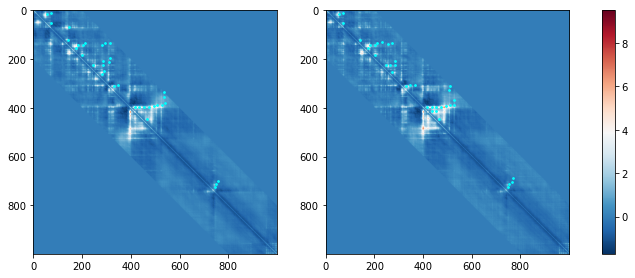

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(pred1_qn[lower:upper, lower:upper], cmap='RdBu_r')
axs[0].scatter(pltcoords1[1], pltcoords1[0], s=3, color='cyan')
im = axs[1].imshow(pred2_qn[lower:upper, lower:upper], cmap='RdBu_r')
axs[1].scatter(pltcoords2[1], pltcoords2[0], s=3, color='cyan')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.75)
plt.show()

In [175]:
coords1[1] - coords1[0]

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
       110, 110, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122,
       122, 122, 122, 122, 132, 132, 132, 132, 132, 132, 132, 132, 132,
       132, 132, 132, 132, 132, 132, 144, 144, 144, 144, 144, 144, 144,
       144, 144, 144, 144, 144, 144, 154, 154, 154, 154, 154, 154, 154,
       154, 154, 154, 154, 154, 154, 166, 166, 166, 166, 166, 166, 166,
       166, 166, 166, 166, 166, 176, 176, 176, 176, 176, 176, 176, 176,
       176, 176, 176, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188,
       200, 200, 200, 200, 200, 200, 200, 200, 200])

In [184]:
x, y = coords1[:,0]
s = abs(x - y) // 2
x, y, s

(389, 489, 50)

In [185]:
np.mean((pred1_qn - pred2_qn)[x:y, x:y])

0.08551638054237992

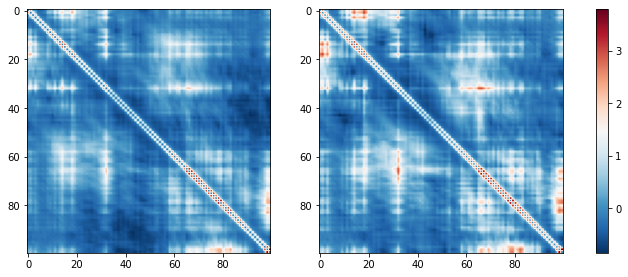

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(pred1_qn[x:y, x:y], cmap='RdBu_r')
im = axs[1].imshow(pred2_qn[x:y, x:y], cmap='RdBu_r')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.75)
plt.show()

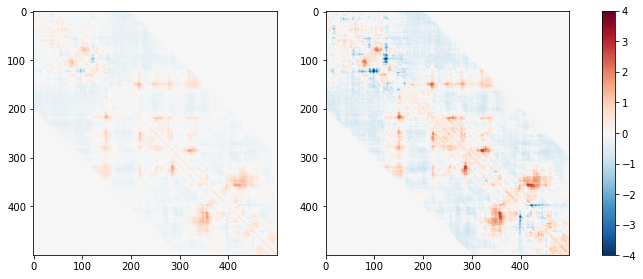

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow((pred1-pred2)[3250:3750, 3250:3750], cmap='RdBu_r', vmax=4, vmin=-4)
im = axs[1].imshow((pred1_norm2-pred2_norm2)[3250:3750, 3250:3750], cmap='RdBu_r', vmax=4, vmin=-4)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.75)
plt.show()

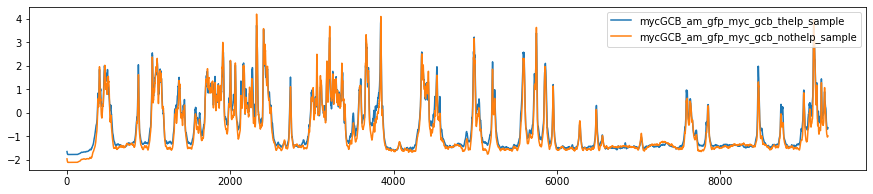

In [146]:
plt.figure(figsize=(15,3))
plt.plot(topdom(pred1_norm, 10), label=ct1)
plt.plot(topdom(pred2_norm, 10), label=ct2)
plt.legend()
plt.show()

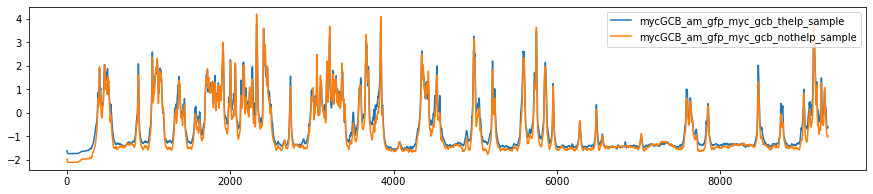

In [145]:
plt.figure(figsize=(15,3))
plt.plot(topdom(pred1_norm2, 10), label=ct1)
plt.plot(topdom(pred2_norm2, 10), label=ct2)
plt.legend()
plt.show()

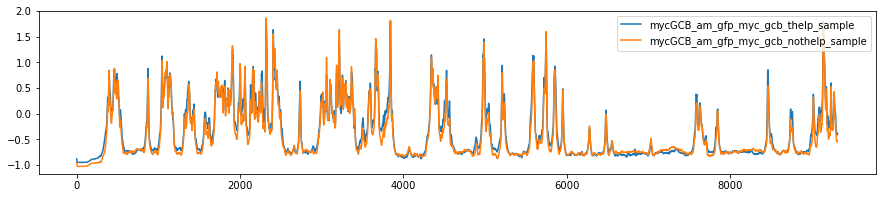

In [187]:
plt.figure(figsize=(15,3))
plt.plot(topdom(pred1_qn, 10), label=ct1)
plt.plot(topdom(pred2_qn, 10), label=ct2)
plt.legend()
plt.show()

In [148]:
np.allclose(pred2_norm, pred2_norm2)

False

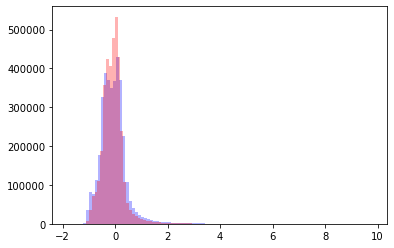

In [156]:
plt.hist(pred1[pred1!=0].ravel(), color='blue', alpha=0.3, bins=100)
plt.hist(pred2[pred2!=0].ravel(), color='red', alpha=0.3, bins=100)
plt.show()

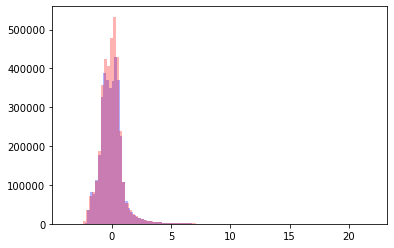

In [157]:
plt.hist(pred1_norm[pred1_norm!=0].ravel(), color='blue', alpha=0.3, bins=100)
plt.hist(pred2_norm[pred2_norm!=0].ravel(), color='red', alpha=0.3, bins=100)
plt.show()

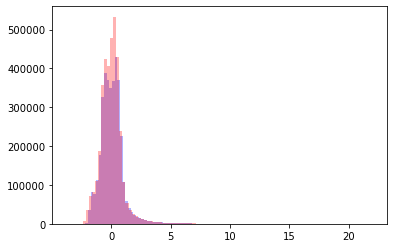

In [158]:
plt.hist(pred1_norm2[pred1_norm2!=0].ravel(), color='blue', alpha=0.3, bins=100)
plt.hist(pred2_norm2[pred2_norm2!=0].ravel(), color='red', alpha=0.3, bins=100)
plt.show()

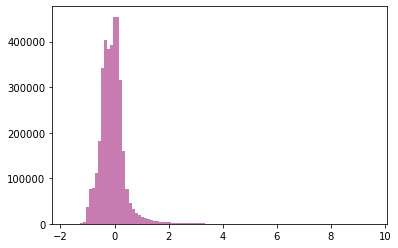

In [160]:
plt.hist(pred1_qn[pred1_qn!=0].ravel(), color='blue', alpha=0.3, bins=100)
plt.hist(pred2_qn[pred2_qn!=0].ravel(), color='red', alpha=0.3, bins=100)
plt.show()

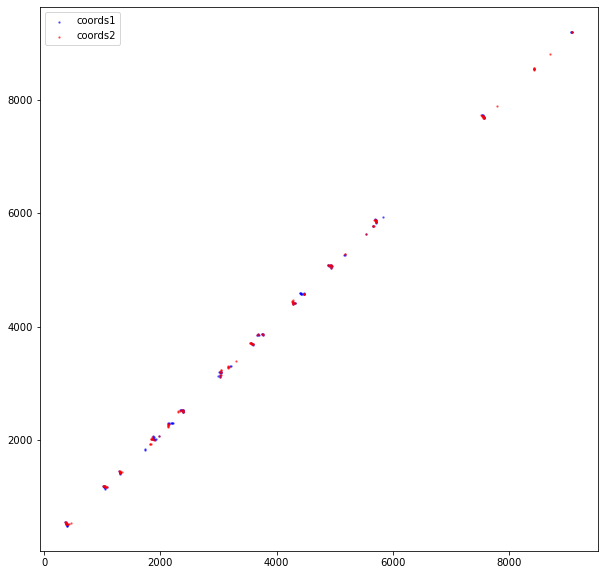

In [213]:
plt.figure(figsize=(10, 10))
plt.scatter(coords1[0], coords1[1], s=2, alpha=0.5, color='blue', label='coords1')
plt.scatter(coords2[0], coords2[1], s=2, alpha=0.5, color='red', label='coords2')
plt.legend()
plt.show()

In [212]:
count = 0
for i in range(coords1.shape[1]):
    for j in range(coords2.shape[1]):
        if np.allclose(coords1[:,i], coords2[:,j], atol=2):
            count += 1
            break
count

59